In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

In [2]:
# equations from supplement of Nguyen Ba AN, Cvijovic I, ..., Desai MM. Nature 2019.
# paper at https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6938260/

def estimate_drift_kappa(df):
    # code at https://github.com/icvijovic/lineage-tracking/blob/master/barcode_scripts/fit_error_model.py
    n = len(df["end_num"])
    kappa_est = 2* ((np.sqrt(df["end_num"]) - np.sqrt(df["start_num_normed"]))**2).sum()/n
    kappa_error = kappa_est * np.sqrt(2./n)
    lower_bound = kappa_est - 2 * kappa_error
    upper_bound = kappa_est + 2 * kappa_error
    return(kappa_est, lower_bound, upper_bound)

def growth_pdf_fn(r, params):
    a, k = params
    to_return = np.sqrt(np.sqrt(a)/(4*np.pi*k*r**(3/2))) * np.exp(-((np.sqrt(r)-np.sqrt(a))**2)/k)
    return(to_return)

def get_sample_params(growth_pdf, params, tol=1e-6):
    # returns ([upper limit for sampling], [max of pdf])
    curr_val = 1
    total_cdf = 0
    max_val = 0
    curr_pdf = 1
    #while 1-total_cdf > tol:
    while (total_cdf < 0.2) or (curr_pdf > tol):
        #print(total_cdf)
        #print(curr_pdf)
        curr_pdf = growth_pdf(curr_val, params)
        total_cdf += curr_pdf
        max_val = max(max_val, curr_pdf)
        curr_val += 1
    return((curr_val, max_val))

def sample_growth(growth_pdf, growth_params, sample_params, n_samples=1):
    sampled = []
    while len(sampled) < n_samples:
        x_proposed = np.random.uniform(high=sample_params[0])
        y_proposed = growth_pdf(x_proposed, growth_params)
        y_sampled = np.random.uniform(high=sample_params[1])
        if y_sampled < y_proposed:
            sampled.append(x_proposed)
    return(sampled)
    
def simulate_MC_drift_adjacent(df, a, kappa):
    df["mean_growth"] = a*df["start_num_normed"]
    sampled = []
    for i in range(len(df["mean_growth"])):
        #if i%10==0:
        #    print(i)
        growth_params = (df["mean_growth"].iloc[i], kappa)
        sample_params = get_sample_params(growth_pdf_fn, growth_params)
        #print(sample_params)
        sampled.extend(sample_growth(growth_pdf_fn, growth_params, sample_params))
    df["sampled_growth"] = sampled
    return()

def get_drift_pvals(df, a, kappa, num_iter, CI_quantile):
    df["mean_growth"] = a*df["start_num_normed"]
    pvals = []
    upper_CIs = []
    lower_CIs = []
    lower_i = (1-CI_quantile)/2
    upper_i = int(np.ceil((1 - lower_i)*num_iter))
    lower_i = int(np.floor(lower_i*num_iter))
    for i in range(len(df["mean_growth"])):
        if i%10==0:
            print(i)
        growth_params = (df["mean_growth"].iloc[i], kappa)
        sample_params = get_sample_params(growth_pdf_fn, growth_params)
        sampled = np.array(sorted(sample_growth(growth_pdf_fn, growth_params, sample_params, num_iter)))
        pval = np.sum(sampled > df["end_num"].iloc[i])/num_iter
        pvals.append(pval)
        upper_CIs.append(sampled[upper_i])
        lower_CIs.append(sampled[lower_i])
    df["drift_pval_advantage"] = pvals
    df["drift_upper_CI"] = upper_CIs
    df["drift_lower_CI"] = lower_CIs
    return()

def simulate_pure_birth(df, a, n_seeded, end_cells, n_reads):
    growth_rate = np.log(end_cells/n_seeded)
    mean_growth = n_seeded*df["start_freq"]*np.exp(growth_rate)
    stdev_growth = np.sqrt(n_seeded*df["start_freq"]*np.exp(growth_rate*2) * (1 - np.exp(-growth_rate)))
    sampled_growth = np.random.normal(mean_growth, stdev_growth)
    sampled_growth = np.maximum(0, sampled_growth)
    #print(np.sum(sampled_growth < 0))
    df["PB_growth"] = np.random.poisson(df["total_end"] * sampled_growth/end_cells)
    return()

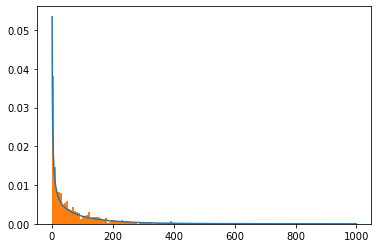

In [376]:
growth_params = (40, 100)
sample_params = get_sample_params(growth_pdf_fn, growth_params)
sampled = sample_growth(growth_pdf_fn, growth_params, sample_params, n_samples=1000)

plt.figure()
xvals = range(1, 1000)
yvals = [growth_pdf_fn(x, growth_params) for x in xvals]
plt.plot(xvals, yvals)
plt.hist(sampled, density=True, bins=100)
plt.show()

In [3]:
APA4 = pd.read_csv("../Ximo_ECB/ECB_4230_APA4/RGC_matrix.txt", sep="\t")
PC1 = pd.read_csv("../Ximo_ECB/ECB_6077_PC1/RGC_matrix.txt", sep="\t")
PC3 = pd.read_csv("../Ximo_ECB/ECB_6077_PD3/RGC_matrix.txt", sep="\t")
PC5 = pd.read_csv("../Ximo_ECB/ECB_6077_PC5/RGC_matrix.txt", sep="\t")

In [4]:
adj_dfs = []
new_dfs = []
for df in [APA4, PC1, PC3, PC5]:
    replicates = []
    timepoints = []
    for sample_name in df["sample"]:
        splitted = sample_name.split("_")
        replicates.append(splitted[3])
        if len(splitted) > 4:
            timepoints.append(int(splitted[4][1:]))
        else:
            timepoints.append(0)
    df["rep"] = replicates
    df["time"] = timepoints
    read_filter = np.sum(df.iloc[:,1:-2], axis=1) > 100000
    df = df[read_filter]
    new_dfs.append(df)
    
    long_df = pd.wide_to_long(df, stubnames=["RG"], i="sample", j="BC").reset_index()
    all_reps = list(set(df[df["time"]>0]["rep"]))
    to_concat = []
    for rep in all_reps:
        only_rep = long_df[long_df["rep"]==rep].sort_values(by="time")
        all_times = list(set(only_rep["time"]))
        all_times.sort()
        prev_time = all_times[0]
        for time in all_times[1:]:
            if time - prev_time == 1:
                curr = only_rep[only_rep["time"]==time]
                curr = curr.sort_values(by="BC")[["BC", "rep", "RG"]]
                curr["start_num"] = only_rep[only_rep["time"]==prev_time].sort_values(by="BC")["RG"].tolist()
                curr["end_num"] = curr["RG"]
                curr.drop(columns=["RG"], inplace=True)
                curr["time"] = prev_time
                curr["end_num_normed"] = np.sum(curr["start_num"])*curr["end_num"]/np.sum(curr["end_num"])
                curr["start_num_normed"] = np.sum(curr["end_num"])*curr["start_num"]/np.sum(curr["start_num"])
                curr["start_freq"] = curr["start_num"]/np.sum(curr["start_num"])
                curr["end_freq"] = curr["end_num"]/np.sum(curr["end_num"])
                curr["total_end"] = np.sum(curr["end_num"])
                to_concat.append(curr)
            prev_time = time
    adj_dfs.append(pd.concat(to_concat, ignore_index=True))
APA4_adj, PC1_adj, PC3_adj, PC5_adj = adj_dfs
APA4, PC1, PC3, PC5 = new_dfs

In [5]:
APA4

,sample,RG0,RG1,RG2,RG3,RG4,RG5,RG6,RG7,RG8,...,RG6894,RG6895,RG6896,RG6897,RG6898,RG6899,RG6900,RG6901,rep,time
1,4230_AP_A4_R1_T1,6705,4334,16952,3153,19571,502,14473,2818,2510,...,0,0,0,0,0,0,0,0,R1,1
2,4230_AP_A4_R2_T1,6760,9225,6443,6716,23495,432,12650,930,1575,...,0,0,0,0,0,0,0,0,R2,1
3,4230_AP_A4_R3_T1,2739,4115,3282,3110,11717,1435,9793,1970,3776,...,0,0,0,0,0,0,0,0,R3,1
4,4230_AP_A4_R1_T2,84100,10651,79664,7460,8172,1365,7325,14699,3340,...,0,0,0,0,0,0,0,0,R1,2
5,4230_AP_A4_R2_T2,64510,56874,99972,14540,16866,462,10240,755,5142,...,0,0,0,0,0,0,0,0,R2,2
6,4230_AP_A4_R3_T2,66181,20407,31937,28118,28637,29309,20864,21312,36210,...,0,0,0,0,0,0,0,0,R3,2
7,4230_AP_A4_R1_T3,160107,33880,61023,7144,2856,591,2741,10921,1006,...,0,0,0,0,0,0,0,0,R1,3
8,4230_AP_A4_R2_T3,97466,196025,50692,11075,5845,323,3761,108,802,...,0,0,0,0,0,0,0,0,R2,3
9,4230_AP_A4_R3_T3,147105,105607,23975,33813,30007,55995,13149,20900,21515,...,0,0,0,0,0,0,0,0,R3,3
10,4230_AP_A4_R1_T5,838477,29744,806,7548,539,204,1,166,21,...,0,0,0,0,0,0,0,0,R1,5


In [379]:
n_drift = 40
lower_lim = n_drift-2*np.sqrt(n_drift)
upper_lim = n_drift+2*np.sqrt(n_drift)
print(lower_lim, upper_lim)
APA4_filtered = APA4_adj[np.logical_and(APA4_adj["start_num"] <= upper_lim, APA4_adj["start_num"] >= lower_lim)]
PC1_filtered = PC1_adj[np.logical_and(PC1_adj["start_num"] <= upper_lim, PC1_adj["start_num"] >= lower_lim)]
PC3_filtered = PC3_adj[np.logical_and(PC3_adj["start_num"] <= upper_lim, PC3_adj["start_num"] >= lower_lim)]
PC5_filtered = PC5_adj[np.logical_and(PC5_adj["start_num"] <= upper_lim, PC5_adj["start_num"] >= lower_lim)]

27.35088935932648 52.64911064067352


In [380]:
APA4_drift = compute_drift_kappa(APA4_filtered)
print(len(APA4_filtered))
print(APA4_drift)
PC1_drift = compute_drift_kappa(PC1_filtered)
print(len(PC1_filtered))
print(PC1_drift)
PC3_drift = compute_drift_kappa(PC3_filtered)
print(len(PC3_filtered))
print(PC3_drift)
PC5_drift = compute_drift_kappa(PC5_filtered)
print(len(PC5_filtered))
print(PC5_drift)

365
(123.21759674052592, 104.97564530291122, 141.4595481781406)
197
(105.48679560523209, 84.22940365393748, 126.7441875565267)
202
(146.23720190936913, 117.13491101095522, 175.33949280778305)
1382
(39.6393491237053, 36.62344530792222, 42.655252939488385)


In [381]:
PC1_drift = compute_drift_kappa(PC1_filtered)
simulate_MC_drift_adjacent(PC1_filtered, 1, PC1_drift[0])

PC3_drift = compute_drift_kappa(PC3_filtered)
simulate_MC_drift_adjacent(PC3_filtered, 1, PC3_drift[0])

PC5_drift = compute_drift_kappa(PC5_filtered)
simulate_MC_drift_adjacent(PC5_filtered, 1, PC5_drift[0])

APA4_drift = compute_drift_kappa(APA4_filtered)
simulate_MC_drift_adjacent(APA4_filtered, 1, APA4_drift[0])

/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


()

In [382]:
simulate_pure_birth(PC1_filtered, 1, 5e5, 6e6, 3e5)
simulate_pure_birth(PC3_filtered, 1, 5e5, 6e6, 3e5)
simulate_pure_birth(PC5_filtered, 1, 5e5, 6e6, 3e5)
simulate_pure_birth(APA4_filtered, 1, 5e5, 6e6, 3e5)

/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


()

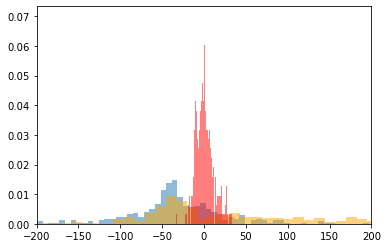

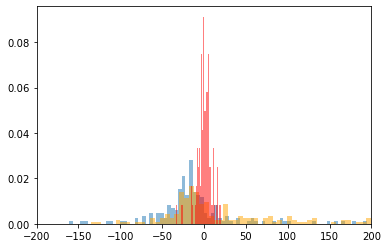

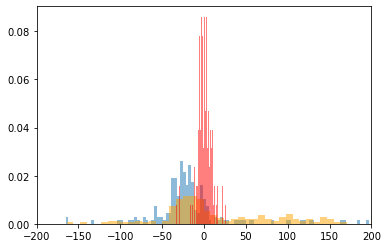

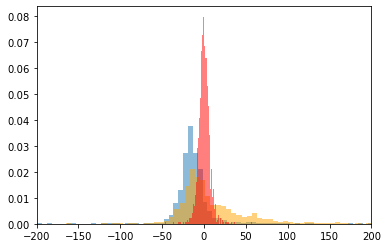

In [383]:
plt.figure()
plt.hist(APA4_filtered["end_num"]-APA4_filtered["start_num_normed"], bins=1000, density=True, alpha=0.5)
plt.hist(APA4_filtered["sampled_growth"]-APA4_filtered["start_num_normed"], bins=100, color="orange", density=True, alpha=0.5)
plt.hist(APA4_filtered["PB_growth"]-APA4_filtered["start_num_normed"], bins=100, color="red", density=True, alpha=0.5)
plt.xlim(-200, 200)
plt.show()

plt.figure()
plt.hist(PC1_filtered["end_num"]-PC1_filtered["start_num_normed"], bins=1000, density=True, alpha=0.5)
plt.hist(PC1_filtered["sampled_growth"]-PC1_filtered["start_num_normed"], bins=100, color="orange", density=True, alpha=0.5)
plt.hist(PC1_filtered["PB_growth"]-PC1_filtered["start_num_normed"], bins=100, color="red", density=True, alpha=0.5)
plt.xlim(-200, 200)
plt.show()

plt.figure()
plt.hist(PC3_filtered["end_num"]-PC3_filtered["start_num_normed"], bins=1000, density=True, alpha=0.5)
plt.hist(PC3_filtered["sampled_growth"]-PC3_filtered["start_num_normed"], bins=100, color="orange", density=True, alpha=0.5)
plt.hist(PC3_filtered["PB_growth"]-PC3_filtered["start_num_normed"], bins=100, color="red", density=True, alpha=0.5)
plt.xlim(-200, 200)
plt.show()

plt.figure()
plt.hist(PC5_filtered["end_num"]-PC5_filtered["start_num_normed"], bins=1000, density=True, alpha=0.5)
plt.hist(PC5_filtered["sampled_growth"]-PC5_filtered["start_num_normed"], bins=100, color="orange", density=True, alpha=0.5)
plt.hist(PC5_filtered["PB_growth"]-PC5_filtered["start_num_normed"], bins=100, color="red", density=True, alpha=0.5)
plt.xlim(-200, 200)
plt.show()


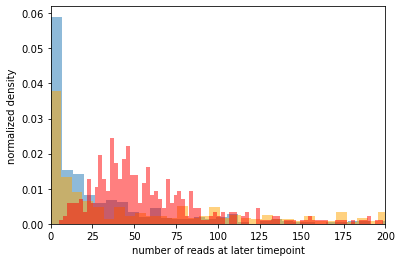

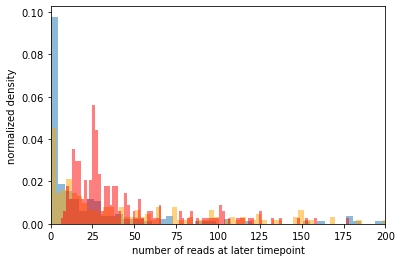

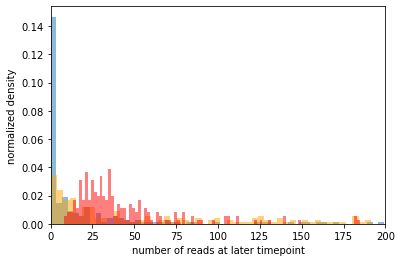

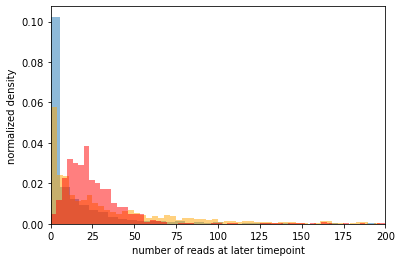

In [480]:
plt.figure()
plt.hist(APA4_filtered["end_num"], bins=1000, density=True, alpha=0.5)
plt.hist(APA4_filtered["sampled_growth"], bins=200, color="orange", density=True, alpha=0.5)
plt.hist(APA4_filtered["PB_growth"], bins=100, color="red", density=True, alpha=0.5)
plt.xlim(0, 200)
plt.xlabel("number of reads at later timepoint")
plt.ylabel("normalized density")
plt.show()

plt.figure()
plt.hist(PC1_filtered["end_num"], bins=1000, density=True, alpha=0.5)
plt.hist(PC1_filtered["sampled_growth"], bins=200, color="orange", density=True, alpha=0.5)
plt.hist(PC1_filtered["PB_growth"], bins=100, color="red", density=True, alpha=0.5)
plt.xlim(0, 200)
plt.xlabel("number of reads at later timepoint")
plt.ylabel("normalized density")
plt.show()

plt.figure()
plt.hist(PC3_filtered["end_num"], bins=1000, density=True, alpha=0.5)
plt.hist(PC3_filtered["sampled_growth"], bins=200, color="orange", density=True, alpha=0.5)
plt.hist(PC3_filtered["PB_growth"], bins=100, color="red", density=True, alpha=0.5)
plt.xlim(0, 200)
plt.xlabel("number of reads at later timepoint")
plt.ylabel("normalized density")
plt.show()

plt.figure()
plt.hist(PC5_filtered["end_num"], bins=1000, density=True, alpha=0.5)
plt.hist(PC5_filtered["sampled_growth"], bins=200, color="orange", density=True, alpha=0.5)
plt.hist(PC5_filtered["PB_growth"], bins=100, color="red", density=True, alpha=0.5)
plt.xlim(0, 200)
plt.xlabel("number of reads at later timepoint")
plt.ylabel("normalized density")
plt.show()


In [419]:
lower_lim_selection = upper_lim
APA4_select = APA4_adj[APA4_adj["start_num"] >= lower_lim_selection]
PC1_select = PC1_adj[PC1_adj["start_num"] >= lower_lim_selection]
PC3_select = PC3_adj[PC3_adj["start_num"] >= lower_lim_selection]
PC5_select = PC5_adj[PC5_adj["start_num"] >= lower_lim_selection]

In [486]:
APA4_adj

,BC,rep,start_num,end_num,time,end_num_normed,start_num_normed,start_freq,end_freq,total_end
0,0,R1,6705,84100,1,42385.245089,13303.933924,0.046136,0.291644,288365
1,1,R1,4334,10651,1,5367.957734,8599.440660,0.029821,0.036936,288365
2,2,R1,16952,79664,1,40149.562006,33635.837118,0.116643,0.276261,288365
3,3,R1,3153,7460,1,3759.737555,6256.122843,0.021695,0.025870,288365
4,4,R1,19571,8172,1,4118.575777,38832.407281,0.134664,0.028339,288365
...,...,...,...,...,...,...,...,...,...,...
103480,6897,R3,0,2,9,1.839500,0.000000,0.000000,0.000004,512722
103481,6898,R3,0,2,9,1.839500,0.000000,0.000000,0.000004,512722
103482,6899,R3,0,2,9,1.839500,0.000000,0.000000,0.000004,512722
103483,6900,R3,0,2,9,1.839500,0.000000,0.000000,0.000004,512722


In [488]:
only_rep = APA4_adj[APA4_adj["rep"]=="R1"][["BC", "start_num", "end_num", "time"]]
only_rep.to_csv("../ECB_input_data/full_long_data/APA4_R1.csv", index=False)

In [539]:
only_rep

,BC,start_num,end_num,time
0,0,4443,5595,1
1,1,80243,61050,1
2,2,37153,32839,1
3,4,390,380,1
4,6,6798,2930,1
...,...,...,...,...
105276,61,1075,4050,9
105332,117,107,809,9
105396,181,173,595,9
105549,334,106,272,9


In [538]:
#APA4_adj, PC1_adj, PC3_adj, PC5_adj

only_rep = PC5_adj[PC5_adj["rep"]=="R1"][["BC", "start_num", "end_num", "time"]]
only_rep = only_rep[only_rep["start_num"] >= 100]
print(len(only_rep["time"]))
only_rep.to_csv("../ECB_input_data/trimmed_long_data/above_100/PC5_R1.csv", index=False)

887


In [6]:
sample_df = pd.read_csv("../Ximo_ECB/sample_passage.csv")

In [541]:
to_save

,time,counted,passaged,sampled
14,1,2880000,500000,145333
25,2,10320000,500000,151535
40,3,11610000,500000,111494
55,4,1566000,500000,288367
70,5,10032000,500000,354026
85,6,564400,500000,473239
100,7,10881000,500000,326534
115,8,3008000,400000,406383
130,9,4264000,250000,568703
145,10,7488000,250000,907143


In [492]:
set(sample_df["Organoid"])

{'ECB 0891 P B2 37k',
 'ECB 4230 AP A4 100k',
 'ECB 6077 C1 100k',
 'ECB 6077 C5 300k',
 'ECB 6077 D3 100k'}

In [46]:
rep = "R3"
df_samples = sample_df[sample_df["Organoid"]=='ECB 4230 AP A4 100k']
df_samples = df_samples[df_samples["Replicate"]==rep]
df_samples["time"] = [int(x[1:]) for x in df_samples["Time point"]]
df_samples["counted"] = [int(x) for x in df_samples["Total viable cells"]]
df_samples["passaged"] = [int(x) for x in df_samples["Cells seeded"]]
sampled_counts = APA4[APA4["rep"] == rep]
sampled_counts.set_index("time", inplace=True)
sampled_counts = np.sum(sampled_counts.iloc[:,1:-1], axis=1)
df_samples["sampled"] = [sampled_counts[x] if x in sampled_counts else 0 for x in df_samples["time"]]
to_save = df_samples[["time", "counted", "passaged", "sampled"]]
print(len(to_save["time"]))
to_save.to_csv("../ECB_input_data/sampling_params/APA4_"+rep+".csv", index=False)

19


In [47]:
to_save

,time,counted,passaged,sampled
31,1,3060000,500000,111493
46,2,6840000,500000,473237
61,3,2496000,500000,568700
76,4,12384000,500000,0
91,5,2340000,500000,689179
106,6,11844000,500000,1103474
121,7,6290000,400000,0
136,8,7854000,250000,523167
151,9,7332000,250000,471576
166,10,5336000,250000,512722


In [25]:
df_samples

,Organoid,Replicate,Viability,Total viable cells,Cells per well,Cells seeded,Date,Time point,time,counted,passaged
12,ECB 6077 D3 100k,R1,89%,3026000,20000,500000,7/21/17,T1,1,3026000,500000
23,ECB 6077 D3 100k,R1,88%,13376000,20000,500000,8/6/17,T2,2,13376000,500000
38,ECB 6077 D3 100k,R1,87%,8352000,20000,500000,8/22/17,T3,3,8352000,500000
53,ECB 6077 D3 100k,R1,94%,4700000,20000,500000,9/2/17,T4,4,4700000,500000
68,ECB 6077 D3 100k,R1,83%,9628000,20000,500000,9/19/17,T5,5,9628000,500000
83,ECB 6077 D3 100k,R1,90%,9990000,20000,500000,10/3/17,T6,6,9990000,500000
98,ECB 6077 D3 100k,R1,95%,12255000,20000,500000,10/17/17,T7,7,12255000,500000
113,ECB 6077 D3 100k,R1,91%,10374000,15000,400000,10/30/17,T8,8,10374000,400000
128,ECB 6077 D3 100k,R1,57%,10260000,10000,250000,11/14/17,T9,9,10260000,250000
143,ECB 6077 D3 100k,R1,94%,9306000,10000,250000,11/28/17,T10,10,9306000,250000


In [420]:
PC1_drift = compute_drift_kappa(PC1_filtered)
get_drift_pvals(PC1_select, 1, PC1_drift[0], 1000, 0.95)

/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610


/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

()

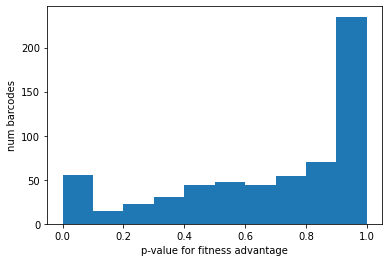

In [421]:
plt.figure()
plt.hist(PC1_select["drift_pval_advantage"])
plt.xlabel("p-value for fitness advantage")
plt.ylabel("num barcodes")
plt.show()


In [422]:
reject, corrected, _, _ = multipletests(PC1_select["drift_pval_advantage"], method="fdr_bh")
PC1_select["pval_adj"] = corrected

/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


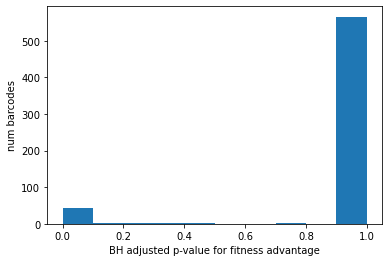

In [423]:
plt.figure()
plt.hist(PC1_select["pval_adj"])
plt.xlabel("BH adjusted p-value for fitness advantage")
plt.ylabel("num barcodes")
plt.show()


In [431]:
PC1_select["naive_fit"] = (PC1_select["end_num"])/(PC1_select["start_num_normed"])

/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


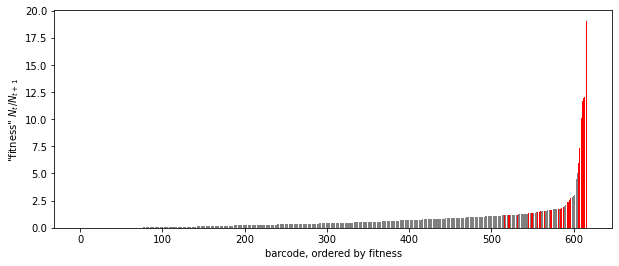

In [457]:
to_plot = PC1_select.sort_values(by="naive_fit")
to_plot["color"] = ["grey" if x > 0.05 else "red" for x in to_plot["pval_adj"]]

plt.figure(figsize=(10,4))
plt.bar(x=range(len(to_plot)), height=to_plot["naive_fit"], color=to_plot["color"])
plt.xlabel("barcode, ordered by fitness")
plt.ylabel('"fitness" $N_t/N_{t+1}$')
plt.show()

In [461]:
to_plot = PC1_select[np.isin(PC1_select["time"], [1,2,3])]
to_plot["color"] = ["grey" if x > 0.05 else "red" for x in to_plot["pval_adj"]]
BCs_to_keep = pd.value_counts(to_plot["BC"])
BCs_to_keep = BCs_to_keep[BCs_to_keep == 9].index.tolist()
to_plot = to_plot[np.isin(to_plot["BC"], BCs_to_keep)]

#to_plot = to_plot[to_plot["rep"] == "R1"]

/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


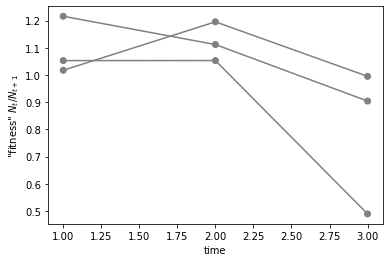

In [479]:
BC_to_plot = to_plot[to_plot["BC"] == 1]
plt.figure()
#plt.scatter(BC_to_plot["time"], BC_to_plot["naive_fit"], color=BC_to_plot["color"])
plt.plot(BC_to_plot[BC_to_plot["rep"]=="R1"]["time"], BC_to_plot[BC_to_plot["rep"]=="R1"]["naive_fit"], color="grey")
plt.plot(BC_to_plot[BC_to_plot["rep"]=="R2"]["time"], BC_to_plot[BC_to_plot["rep"]=="R2"]["naive_fit"], color="grey")
plt.plot(BC_to_plot[BC_to_plot["rep"]=="R3"]["time"], BC_to_plot[BC_to_plot["rep"]=="R3"]["naive_fit"], color="grey")
plt.scatter(BC_to_plot["time"], BC_to_plot["naive_fit"], color=BC_to_plot["color"], zorder=10)
plt.xlabel("time")
plt.ylabel('"fitness" $N_t/N_{t+1}$')
plt.show()

In [473]:
to_plot[to_plot["pval_adj"] < 0.05]

,BC,rep,start_num,end_num,time,end_num_normed,start_num_normed,start_freq,end_freq,total_end,mean_growth,drift_pval_advantage,drift_upper_CI,drift_lower_CI,pval_adj,naive_fit,color
4,4,R1,11149,22973,1,26115.912763,9807.276480,0.035800,0.083860,273944,9807.276480,0.000,12392.205661,7272.088145,0.000000,2.342444,red
7,8,R1,11566,15302,1,17395.451056,10174.092723,0.037139,0.055858,273944,10174.092723,0.000,13306.751363,7453.843784,0.000000,1.504016,red
14,16,R1,1862,4132,1,4697.294717,1637.918092,0.005979,0.015083,273944,1637.918092,0.000,2939.083903,601.230247,0.000000,2.522715,red
8342,0,R1,74985,83928,2,85475.294280,73627.603543,0.273724,0.312017,268985,73627.603543,0.001,81215.084756,66145.908670,0.016237,1.139899,red
8344,2,R1,19842,27993,2,28509.078172,19482.815356,0.072431,0.104069,268985,19482.815356,0.000,23291.258985,15705.883269,0.000000,1.436805,red
8346,4,R1,22973,33327,2,33941.415648,22557.137243,0.083860,0.123899,268985,22557.137243,0.000,27307.468185,18663.181943,0.000000,1.477448,red
16684,0,R1,83928,75832,3,139929.550596,45483.088232,0.312017,0.520213,145771,45483.088232,0.000,51724.146946,38848.263180,0.000000,1.667257,red
41712,2,R2,53385,30042,1,73217.222865,21904.575279,0.073976,0.101458,296103,21904.575279,0.000,25964.666083,17933.899049,0.000000,1.371494,red
41714,4,R2,22670,25366,1,61821.053032,9301.802409,0.031414,0.085666,296103,9301.802409,0.000,12191.238216,6748.763017,0.000000,2.726998,red
41717,8,R2,16149,11660,1,28417.309720,6626.149409,0.022378,0.039378,296103,6626.149409,0.000,9104.066903,4534.700403,0.000000,1.759695,red


In [417]:
PC1_select

,BC,rep,start_num,end_num,time,end_num_normed,start_num_normed,start_freq,end_freq,total_end,mean_growth,drift_pval_advantage,drift_pval_disadvantage,drift_upper_CI,drift_lower_CI,pval_adj,naive_fit
0,0,R1,78553,74985,1,85243.621580,69099.559543,0.252240,0.273724,273944,69099.559543,0.931,0.069,76821.893734,61550.586844,1.000000,0.081739
1,1,R1,20320,21731,1,24703.996006,17874.594858,0.065249,0.079326,273944,17874.594858,0.975,0.025,21760.477289,14457.982466,1.000000,0.195349
2,2,R1,17511,19842,1,22556.563838,15403.643237,0.056229,0.072431,273944,15403.643237,0.994,0.006,19134.896728,12090.085310,1.000000,0.253182
3,3,R1,77978,54231,1,61650.287949,68593.757769,0.250393,0.197964,273944,68593.757769,0.000,1.000,76282.742294,61438.463657,0.000000,-0.234945
4,4,R1,11149,22973,1,26115.912763,9807.276480,0.035800,0.083860,273944,9807.276480,1.000,0.000,12821.861096,7020.342736,1.000000,0.851137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141909,98,R3,59,118,17,169.368488,41.105640,0.000141,0.000404,292197,41.105640,0.763,0.237,375.100036,0.454601,0.873416,1.038942
141926,115,R3,163,61,17,87.554896,113.563038,0.000389,0.000209,292197,113.563038,0.427,0.573,518.876127,0.781868,0.634841,-0.613991
141929,118,R3,90,45,17,64.589678,62.703518,0.000215,0.000154,292197,62.703518,0.480,0.520,447.644119,0.403958,0.671441,-0.325598
141953,142,R3,68,1,17,1.435326,47.375991,0.000162,0.000003,292197,47.375991,0.053,0.947,422.778933,0.443035,0.171209,-3.185856


In [151]:
PC3_filtered[PC3_filtered["end_num"]-PC3_filtered["start_num_normed"]>500]

,BC,rep,start_num,end_num,time,end_num_normed,start_num_normed
37506,54,R1,38,1927,7,892.589101,82.037748
37510,58,R1,33,2777,7,1286.310292,71.243308
84314,47,R2,51,3226,7,1013.946585,162.262986
84411,144,R2,32,1123,7,352.964047,101.812069
121766,47,R3,36,3375,7,981.931193,123.735758
121777,58,R3,28,2915,7,848.097608,96.238923
140628,183,R3,28,676,9,884.023147,21.411204


In [152]:
APA4_filtered[APA4_filtered["end_num"]-APA4_filtered["start_num_normed"]>500]

,BC,rep,start_num,end_num,time,end_num_normed,start_num_normed
13860,65,R1,36,1697,5,3194.598626,19.123529
48332,41,R2,29,3235,5,2565.908010,36.562106
69071,84,R3,39,962,1,226.643872,165.537236
82827,41,R3,47,6590,5,4115.810259,75.253712
82850,65,R3,31,3253,5,2031.673865,49.635427


In [304]:
PC5_filtered[PC5_filtered["end_num"]-PC5_filtered["start_num_normed"]<-100]

,BC,rep,start_num,end_num,time,end_num_normed,start_num_normed,start_freq,end_freq,total_end,mean_growth,sampled_growth,PB_growth
70407,266,R1,55,4,7,1.913648,114.963667,0.000222,0.000008,518923,114.963667,57.203750,130
70539,398,R1,49,0,7,0.000000,102.422176,0.000197,0.000000,518923,102.422176,19.770544,98
105239,21,R1,63,155,9,35.340833,276.309277,0.000363,0.000204,760754,276.309277,250.050982,323
105243,27,R1,42,61,9,13.908328,184.206185,0.000242,0.000080,760754,184.206185,200.436135,235
105248,32,R1,44,59,9,13.452317,192.977908,0.000254,0.000078,760754,192.977908,283.819991,183
105446,231,R1,56,18,9,4.104097,245.608246,0.000323,0.000024,760754,245.608246,564.228033,293
105464,249,R1,54,115,9,26.220618,236.836523,0.000311,0.000151,760754,236.836523,204.644185,242
105574,359,R1,54,52,9,11.856279,236.836523,0.000311,0.000068,760754,236.836523,381.136577,207
106031,816,R1,55,95,9,21.660510,241.222385,0.000317,0.000125,760754,241.222385,467.095397,209
106151,936,R1,46,99,9,22.572532,201.749631,0.000265,0.000130,760754,201.749631,279.979776,220


In [11]:
only_rep

,sample,BC,time,rep,RG
4,6077_P_C5_R3_T1,0,1,R3,4789
417202,6077_P_C5_R3_T1,13465,1,R3,0
354427,6077_P_C5_R3_T1,11440,1,R3,0
214183,6077_P_C5_R3_T1,6916,1,R3,0
157701,6077_P_C5_R3_T1,5094,1,R3,0
...,...,...,...,...,...
147962,6077_P_C5_R3_T12,4779,12,R3,0
366109,6077_P_C5_R3_T12,11816,12,R3,0
44515,6077_P_C5_R3_T12,1442,12,R3,0
366016,6077_P_C5_R3_T12,11813,12,R3,0


In [312]:
read_filter = np.sum(PC1.iloc[:,1:-2], axis=1) > 100000

In [314]:
temp = PC1[read_filter]

In [179]:
read_filter

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10    False
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37     True
38     True
dtype: bool

In [315]:
np.sum(temp.iloc[:,1:-2], axis=1)

0     331394
1     657475
2     311422
3     273944
4     268985
5     145771
6     381973
7     806502
8     780190
11    585426
12    311997
13    721651
14    296103
15    328442
16    240970
17    264720
18    215600
19    647551
21    785404
23    298503
24    142109
25    391254
27    468160
28    336529
29    323399
30    281725
31    322751
32    240611
33    859186
34    596734
35    208738
36    322430
37    419398
38    292197
dtype: int64

In [345]:
np.sum(PC5.iloc[:,1:-2], axis=1)

0     567661
1     632728
2     473199
3     431148
4     619562
5     232179
6     303685
7     216494
8     234237
9     259020
10    260439
11    197648
12    104227
13    145986
14    230206
15    312459
16    364580
17    248259
18    145566
19    123604
20    518923
21    813098
22    791275
23    173456
24    133346
25    367750
26    760754
28    296221
29    460513
30    272980
dtype: int64

In [481]:
PC1_filtered

,BC,rep,start_num,end_num,time,end_num_normed,start_num_normed,start_freq,end_freq,total_end,mean_growth,sampled_growth,PB_growth
23,26,R1,43,1,1,1.136809,37.825176,0.000138,0.000004,273944,37.825176,6.571827,28
46,49,R1,47,0,1,0.000000,41.343797,0.000151,0.000000,273944,41.343797,5.555968,44
62,65,R1,28,0,1,0.000000,24.630347,0.000090,0.000000,273944,24.630347,19.254792,24
63,66,R1,47,16,1,18.188944,41.343797,0.000151,0.000058,273944,41.343797,266.960478,37
73,76,R1,46,0,1,0.000000,40.464142,0.000148,0.000000,273944,40.464142,73.230646,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142238,427,R3,28,0,17,0.000000,19.507761,0.000067,0.000000,292197,19.507761,424.000223,22
142260,449,R3,51,22,17,31.577176,35.531993,0.000122,0.000075,292197,35.531993,91.165030,39
142261,450,R3,50,7,17,10.047283,34.835288,0.000119,0.000024,292197,34.835288,28.479270,37
142337,526,R3,41,91,17,130.614681,28.564936,0.000098,0.000311,292197,28.564936,1.588029,26
